# Anomnaly Detection

This notebook was created as an extension to the `evaluate_detection.py` script.

In [212]:
# import
import pickle
import yaml
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.ticker as ticker
# Inside your plotting function/loop
formatter = ticker.FormatStrFormatter('%.2f')  # Change to the desired format, e.g., '%.3f' for three decimal places

from fault_management_uds.plots import visualize_confusion, visualize_roc_auc, visualize_metric_matrix
from fault_management_uds.config import data_label_hue_map, data_label_hue_order, anomaly_hue_map, anomaly_hue_order


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, condition_to_meta

In [214]:
model_save_path = 'transformer/7_anomalous/iteration=0_250206_0903 copy'
data_type = 'val'  

model_save_folder = MODELS_DIR / model_save_path #/ '1_split'
anomalous_path = MODELS_DIR / model_save_path / '1_split' / 'anomalous'
results_folder = anomalous_path / data_type

eval_path = MODELS_DIR / model_save_path / '1_split' / 'evaluation'
eval_folder = eval_path / data_type


In [ ]:
# Load the results
with open(results_folder / 'anomaly_prediction_results_full.pkl', 'rb') as f:
    results = pickle.load(f)

print(results.keys())

config = yaml.load(open(model_save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)

dict_keys(['Valid index', 'Starttime', 'Data label', 'Actual', 'Combined', 'Target', 'Residuals', 'Final hidden', 'IG'])


In [13]:
# rename the key in dict
results['Final Hidden'] = results.pop('Final hidden')
results['Multi-Feature'] = results.pop('Combined')
results['Data Label'] = results.pop('Data label')

In [14]:
methods = ['Target', 'Final Hidden', 'Residuals', 'IG', 'Multi-Feature']

In [15]:
# set save folder
save_folder = eval_folder / 'anomaly_detection'
os.makedirs(save_folder, exist_ok=True)

# Thresholding

In [16]:
if data_type == 'val':
    optimal_thresholds = {}
    for i, key in enumerate(methods):
        # ROC curve
        fpr, tpr, thresholds = roc_curve(results['Actual'], results[key]['Decision Function'])

        # Don't use the first and last threshold
        fpr = fpr[1:-1]
        tpr = tpr[1:-1]
        thresholds = thresholds[1:-1]

        # Calculate Youden's index
        youden_index = tpr - fpr
        optimal_threshold = thresholds[np.argmax(youden_index)]

        print(f'Optimal Threshold for {key}: {optimal_threshold}')
        optimal_thresholds[key] = optimal_threshold

    # Save the optimal thresholds
    with open(anomalous_path / 'optimal_thresholds.pkl', 'wb') as f:
        pickle.dump(optimal_thresholds, f)

# Load the optimal thresholds, ensure they exist
if os.path.exists(anomalous_path / 'optimal_thresholds.pkl'):
    with open(anomalous_path / 'optimal_thresholds.pkl', 'rb') as f:
        optimal_thresholds = pickle.load(f)
else:
    raise FileNotFoundError('Optimal thresholds not found')

# insert the optimal threshold to the results
for key in methods:
    results[key]['Optimal Threshold'] = optimal_thresholds[key]
    # Update the predicted labels
    results[key]['Predicted'] = results[key]['Decision Function'] > optimal_thresholds[key]

Optimal Threshold for Target: 0.045446631864508036
Optimal Threshold for Final Hidden: 0.17253181202457324
Optimal Threshold for Residuals: 0.136440749578284
Optimal Threshold for IG: -0.046551006196230205
Optimal Threshold for Multi-Feature: -0.02653451620469699


# Sigma-3

In [17]:
# add the sigma-3 results
starttimes = pd.to_datetime(results['Starttime'])

with open(eval_folder / f'output.pkl', 'rb') as f:
    output = pickle.load(f)

timestamps = output['timestamps']
# use only the first step

residuals = abs(output['predictions'][:,:,0].flatten() - output['targets'][:,:,0].flatten())

# extract relevant residuals based on the starttimes
residuals = residuals[np.isin(timestamps, starttimes)]

# mask = np.in1d(timestamps, starttimes)  # Create a boolean mask
# residuals = residuals[mask]  # Apply the mask to extract relevant residuals

# starttimes_set = set(starttimes)
# mask = np.array([ts in starttimes_set for ts in timestamps])
# residuals = residuals[mask]

# use the 3-sigma rule to determine the anomalies
sigma = 3
mean = np.mean(residuals)
std = np.std(residuals)

results['Sigma-3'] = {
    'Predicted': residuals > mean + sigma * std,
    'Decision Function': residuals,
    'Optimal Threshold': mean + sigma * std
}


methods = methods + ['Sigma-3']

# Confusion Matrix

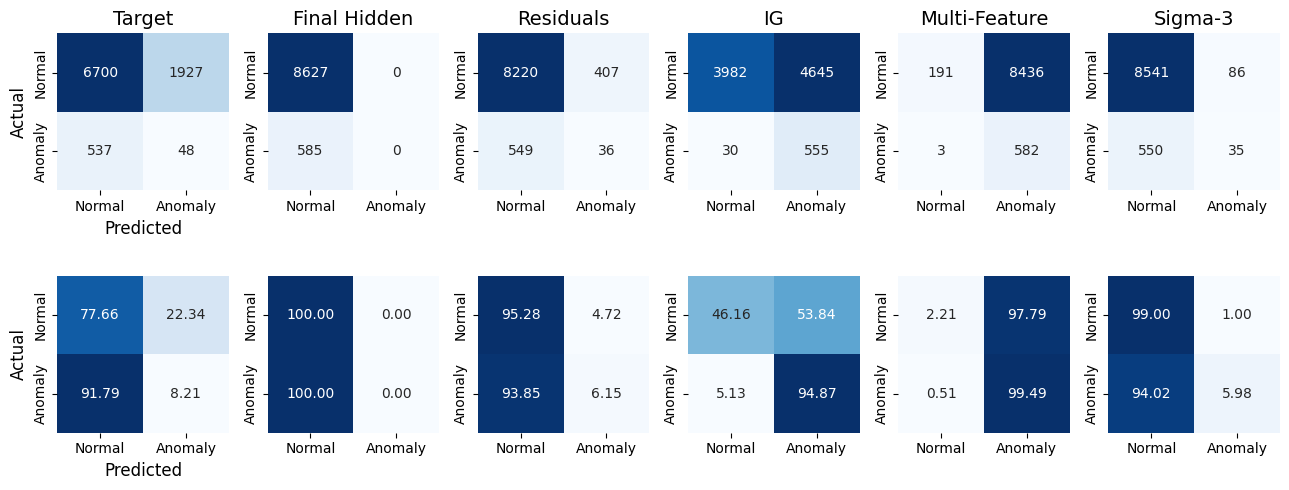

In [18]:
# Overall results
fig, axes = plt.subplots(2, len(methods), figsize=(13, 5))
auc_scores = {}
for i, key in enumerate(methods):
    # Confusion matrix
    conf_matrix = confusion_matrix(results['Actual'], results[key]['Predicted'])
    axes[0, i] = visualize_confusion(axes[0, i], i, key, conf_matrix, 'd', 'Blues')
    # add header
    # Percentage confusion matrix
    conf_matrix = confusion_matrix(results['Actual'], results[key]['Predicted'])
    conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-9) * 100
    axes[1, i] = visualize_confusion(axes[1, i], i, ' ', conf_matrix, ".2f", 'Blues')

plt.tight_layout()
plt.savefig(save_folder / 'cm_overall.png')
plt.show()
plt.close()

# ROC Curve

In [19]:
def visualize_roc_auc(ax, i, key, fpr, tpr, roc_auc, optimal_fpr=None, optimal_tpr=None):   
    ax.plot(fpr, tpr, color='darkorange', lw=2, label="ROC")#, label='AUC: %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random')
    # plot optimal if specified
    if optimal_fpr is not None and optimal_tpr is not None:
        ax.plot(optimal_fpr, optimal_tpr, marker='o', markersize=4, color='navy', label='Threshold')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    if i == 0:
        ax.set_ylabel('TPR', fontsize=12)
        ax.set_xlabel('FPR', fontsize=12)
    ax.legend(loc='lower right')
    ax.set_title(key, fontsize=14)
    return ax


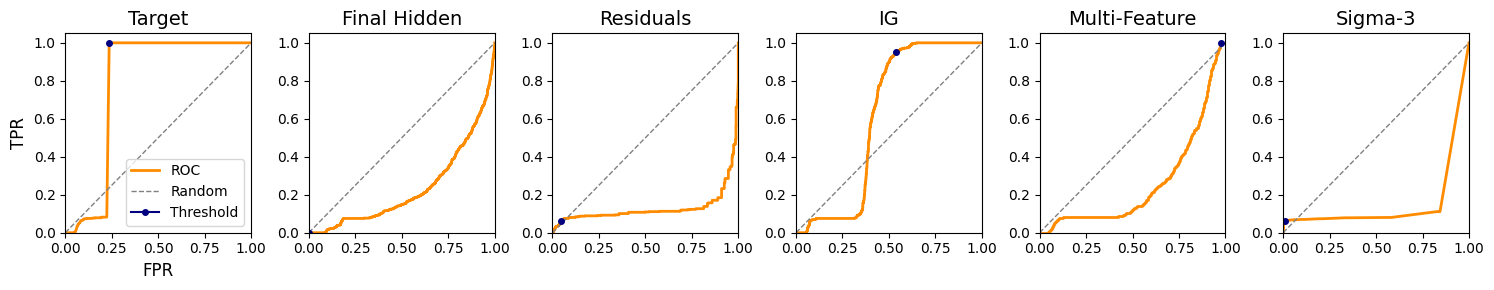

In [20]:
# Visualize the results
# Overall results
fig, axes = plt.subplots(1, len(methods), figsize=(15, 3))
auc_scores = {}
for i, key in enumerate(methods):
    # ROC curve
    fpr, tpr, thresholds = roc_curve(results['Actual'], results[key]['Decision Function'])
    roc_auc = auc(fpr, tpr)
    auc_scores[key] = {'Overall': roc_auc}
    # Find the index based on the optimal threshold
    optimal_threshold = results[key]['Optimal Threshold']
    optimal_index = np.argmin(np.abs(thresholds - optimal_threshold)) # Find the index of the optimal threshold based on smallest difference
    optimal_fpr = fpr[optimal_index]
    optimal_tpr = tpr[optimal_index]
    axes[i] = visualize_roc_auc(axes[i], i, key, fpr, tpr, roc_auc, optimal_fpr, optimal_tpr)
    # remove legend
    if i != 0:
        axes[i].legend().remove()
plt.tight_layout()
plt.savefig(save_folder / 'roc_auc_overall.png')
plt.show()
plt.close()


In [21]:
# For each anomaly
data_label = results['Data Label']
for label in data_label_hue_order[::-1]:
    if label == 'Original':
        continue
    mask = (np.array(data_label) == label) | (np.array(data_label) == 'Original')
    # Create a figure with two subplots side by side
    #fig, axes = plt.subplots(2, len(methods), figsize=(15, 5))
    for i, key in enumerate(methods):
        # # Confusion matrix
        # conf_matrix = confusion_matrix(results['Actual'][mask], results[key]['Predicted'][mask])
        # conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-9) * 100
        # axes[0, i] = visualize_confusion(axes[0, i], i, key, conf_matrix, ".2f", 'Blues')

        # ROC curve
        # check if any tp
        if sum(results['Actual'][mask]) == 0:
            print(f'No TP for {label} in {key}')
            auc_scores[key][label] = 0  
            continue
        else:
            fpr, tpr, _ = roc_curve(results['Actual'][mask], results[key]['Decision Function'][mask])
            roc_auc = auc(fpr, tpr)
            auc_scores[key][label] = roc_auc
        #axes[1, i] = visualize_roc_auc(axes[1, i], i, ' ', fpr, tpr, roc_auc)

    # plt.tight_layout()
    # plt.savefig(save_folder / f'roc_auc_{label}.png')
    # plt.show()
    # plt.close()
    #print('\n')

No TP for Offset in Target
No TP for Offset in Final Hidden
No TP for Offset in Residuals
No TP for Offset in IG
No TP for Offset in Multi-Feature
No TP for Offset in Sigma-3
No TP for Drift in Target
No TP for Drift in Final Hidden
No TP for Drift in Residuals
No TP for Drift in IG
No TP for Drift in Multi-Feature
No TP for Drift in Sigma-3


# AUC metric

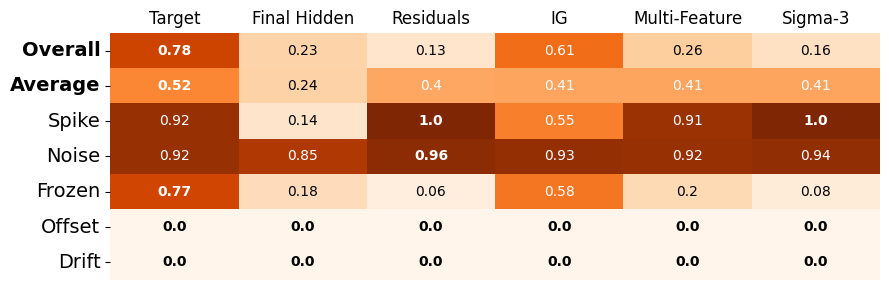

In [22]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
metric_df = pd.DataFrame(auc_scores)
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('AUC', metric_df, 'Oranges', 2, suffix=None, figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('AUC', metric_df, 'Oranges', 2, suffix=None, figsize=(9, 3), save_folder=None)


# Decision Function

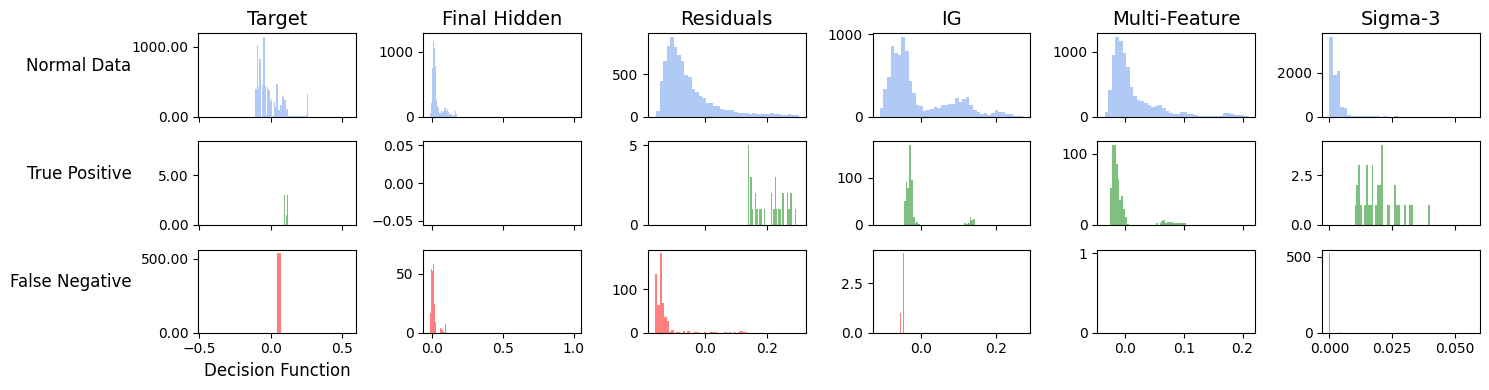

In [165]:
actual = results['Actual']

fig, axes = plt.subplots(3, len(methods), figsize=(15, 4), sharex="col")

# Normal Data, Predicted Synthetic, Not Predicted Synthetic
for i, key in enumerate(methods):
    _predicted_synthetic = (results[key]['Predicted'].astype(int) == 1) & (actual.astype(int) == 1)
    predicted_synthetic = results[key]['Decision Function'][_predicted_synthetic]
    _not_predicted_synthetic = (results[key]['Predicted'].astype(int) == 0) & (actual.astype(int) == 1)
    not_predicted_synthetic = results[key]['Decision Function'][_not_predicted_synthetic]
    _normal_data = (actual.astype(int) == 0)
    normal_data = results[key]['Decision Function'][_normal_data]
    # Visualize the distribution of the decision function
    axes[0, i].hist(normal_data, bins=40, color='cornflowerblue', alpha=0.5)
    axes[1, i].hist(predicted_synthetic, bins=40, color='green', alpha=0.5)
    axes[2, i].hist(not_predicted_synthetic, bins=40, color='red', alpha=0.5)
    axes[0, i].set_title(key, fontsize=14)
    
axes[0, 0].set_ylabel('Normal Data', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[1, 0].set_ylabel('True Positive', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[2, 0].set_ylabel('False Negative', fontsize=12, rotation=0, labelpad=0, ha='right')
axes[0, 0].yaxis.set_major_formatter(formatter)
axes[1, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].set_xlabel('Decision Function', fontsize=12)
fig.align_ylabels()  # ensures all y-labels are properly aligned

plt.tight_layout()
plt.savefig(save_folder / 'decision_function_distribution.png')
plt.show()
plt.close()

# Timing and Coverage

In [166]:
from fault_management_uds.synthetic.synthetic_generator import find_unterrupted_sequences

In [167]:
def get_coverage(predicted, anomaly_start_end):
    # Given start and end of anomalies, find how much of the anomaly is covered by the prediction
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]
    # Find the closest index in both directions
    if len(ones_indices) == 0:
        # do not continue
        #raise ValueError("No anomalies detected")
        return [0] * len(anomaly_start_end)

    coverage = []

    for start, end in anomaly_start_end:
        # extract relevant data
        anomaly_data = predicted[start:end+1]
        
        # Coverage
        coverage.append(anomaly_data.sum() / len(anomaly_data))

    return coverage


def get_timing(predicted, anomaly_start_end, direction='start'):
    # Find all indices where the value is 1
    ones_indices = np.where(predicted == 1)[0]

    # Handle case with no detections
    if len(ones_indices) == 0:
        return [0] * len(anomaly_start_end)

    timing = []

    for i, (start, end) in enumerate(anomaly_start_end):
        if direction == 'start':
            # Filter indices that are after the start
            valid_indices = ones_indices[ones_indices > start] # after start
            if valid_indices.size > 0:
                distances = np.abs(valid_indices - start)
                closest_index = valid_indices[np.argmin(distances)]
                timing.append(closest_index - start)
            # else:
            #     timing.append(np.inf)  # Use inf to indicate no proximity
        elif direction == 'end':
            # Filter indices that are before the end
            #valid_indices = ones_indices[ones_indices < end]
            end_threshold = end + 60 # 60 minutes after the end

            valid_indices = ones_indices[(ones_indices > start) & (ones_indices < end_threshold)]
            if valid_indices.size > 0:
                distances = np.abs(valid_indices - end)
                closest_index = valid_indices[np.argmin(distances)]
                timing.append(closest_index - end)
            # else:
            #     timing.append(np.inf)  # Use inf to indicate no proximity
        else:
            raise ValueError("Invalid direction specified. Use 'start' or 'end'.")

    return timing

In [168]:
# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

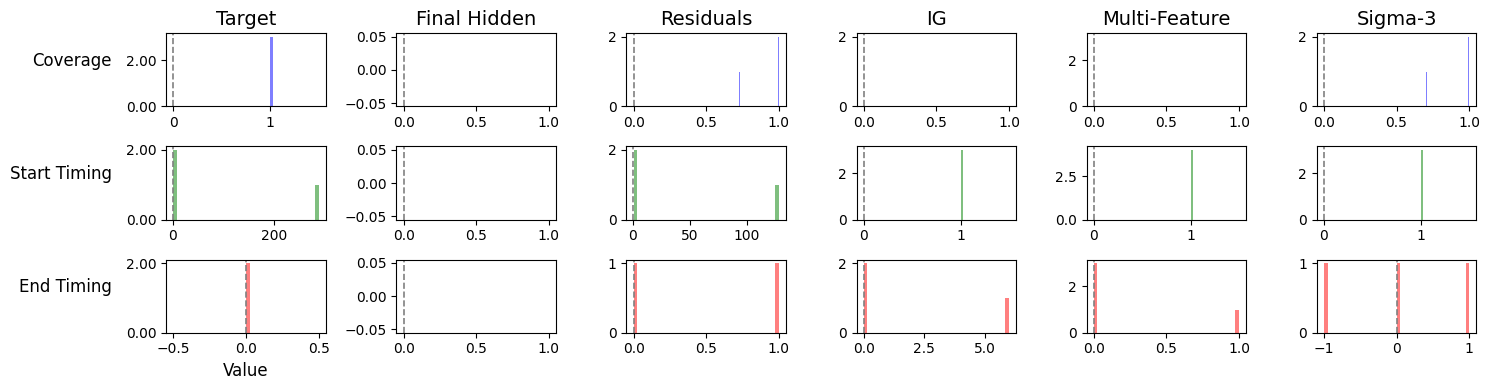

In [169]:
fig, axes = plt.subplots(3, len(methods), figsize=(15, 4))#, sharey=True)

coverage_scores = {}
timing_start_scores = {}
timing_end_scores = {}

for i, key in enumerate(methods):
    coverage = get_coverage(results[key]['Predicted'], anomaly_start_end)
    # for timing, we only want those that are detected
    _anomaly_start_end = [anomaly_start_end[i] for i, cov in enumerate(coverage) if cov > 0]
    start_timing = get_timing(results[key]['Predicted'], _anomaly_start_end, direction='start')
    end_timing = get_timing(results[key]['Predicted'], _anomaly_start_end, direction='end')
    # filter coverage as well
    coverage = [cov for cov in coverage if cov > 0]

    # Store the results
    coverage_scores[key] = {'Overall': np.mean(coverage) if len(coverage) > 0 else 0}
    timing_start_scores[key] = {'Overall': np.mean(start_timing) if len(start_timing) > 0 else 0}
    timing_end_scores[key] = {'Overall': np.mean(end_timing) if len(end_timing) > 0 else 0}
    

    # Visualize the distribution of the decision function
    axes[0, i].hist(coverage, bins=40, color='blue', alpha=0.5)
    axes[1, i].hist(start_timing, bins=40, color='green', alpha=0.5)
    axes[2, i].hist(end_timing, bins=40, color='red', alpha=0.5)
    axes[0, i].set_title(key, fontsize=14)
    # Adding vertical line at x = 0
    for ax in axes[:, i]:  # For all three subplots
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=1.2)
        # ax.text(0.05, ax.get_ylim()[1]*0.9, 'Perfect Timing', color='black', fontsize=10,
        #         horizontalalignment='center', verticalalignment='center')  # Add text label

axes[0, 0].set_ylabel('Coverage', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[1, 0].set_ylabel('Start Timing', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[2, 0].set_ylabel('End Timing', fontsize=12, rotation=0, labelpad=10, ha='right')
axes[0, 0].yaxis.set_major_formatter(formatter)
axes[1, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].yaxis.set_major_formatter(formatter)
axes[2, 0].set_xlabel('Value', fontsize=12)
fig.align_ylabels()  # ensures all y-labels are properly aligned

plt.tight_layout()
plt.savefig(save_folder / 'coverage_timing.png')
plt.show()
plt.close()


the `_anomaly_start_end` only considers classifications with at least 1 successful detection.

# Metric plots of coverage & timing

In [170]:
data_label = results['Data Label']

for i, key in enumerate(methods):
    # For each
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            continue
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
        
        # Only for successful predictions
        start_end = [_anomaly_start_end[i] for i, (start, end) in enumerate(_anomaly_start_end) if mask[start]]
        coverage = get_coverage(results[key]['Predicted'], start_end)
        coverage_scores[key][label] = np.mean(coverage) if len(coverage) > 0 else None
        start_timing = get_timing(results[key]['Predicted'], start_end, direction='start')
        timing_start_scores[key][label] = np.mean(start_timing) if len(start_timing) > 0 else None
        end_timing = get_timing(results[key]['Predicted'], start_end, direction='end')
        timing_end_scores[key][label] = np.mean(end_timing) if len(end_timing) > 0 else None


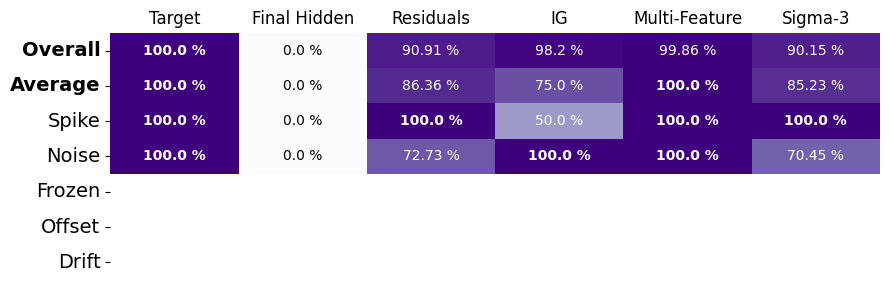

In [171]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
metric_df = pd.DataFrame(coverage_scores) * 100
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('coverage', metric_df, 'Purples', 2, suffix=" %", figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('coverage', metric_df, 'Purples', 2, suffix=" %", figsize=(9, 3), save_folder=None)


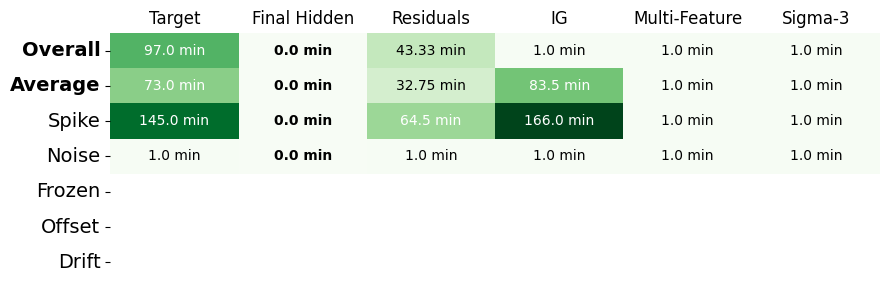

In [172]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
metric_df = pd.DataFrame(timing_start_scores)
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('timing_start', metric_df, 'Greens', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('timing_start', metric_df, 'Greens', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=None)


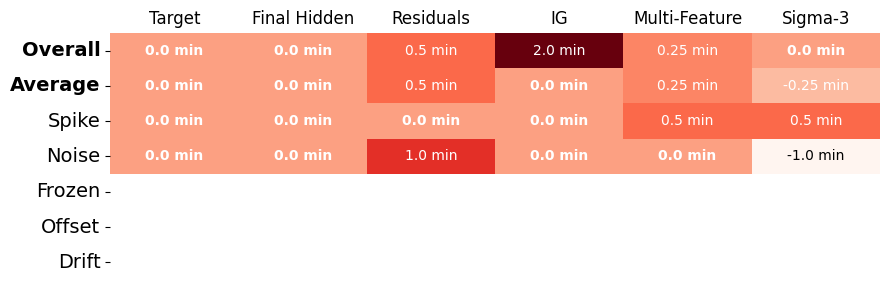

In [173]:
# row ordering
row_order = data_label_hue_order[1:] + ['Average', 'Overall']

# AUC
metric_df = pd.DataFrame(timing_end_scores)
# Calculate the average AUC as well
metric_df.loc['Average'] = metric_df.loc[data_label_hue_order[1:]].mean()
metric_df = metric_df.loc[row_order]
visualize_metric_matrix('timing_end', metric_df, 'Reds', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=save_folder)
visualize_metric_matrix('timing_end', metric_df, 'Reds', 2, suffix=" min", high_best=False, figsize=(9, 3), save_folder=None)


# Successful vs. Unsuccessful Detections

In [174]:
np.array(coverage) > 0

array([], dtype=bool)

In [175]:
data_label = results['Data Label']

# initialize dict
succ_unsucc = {}
succ_unsucc["Overall"] = {
    "Method": [],
    "Successful": [],
    "Unsuccessful": [],
}
for label in data_label_hue_order[::-1]:
    if label == 'Original':
        continue
    succ_unsucc[label] = {
        "Method": [],
        "Successful": [],
        "Unsuccessful": [],
    }


for i, key in enumerate(methods):
    coverage = get_coverage(results[key]['Predicted'], anomaly_start_end)
    succ_unsucc["Overall"]["Method"].append(key)
    succ_unsucc["Overall"]["Successful"].append(np.sum(np.array(coverage) > 0))
    succ_unsucc["Overall"]["Unsuccessful"].append(np.sum(np.array(coverage) == 0))
    
    # For each
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            continue
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
        
        # Only for successful predictions
        start_end = [_anomaly_start_end[i] for i, (start, end) in enumerate(_anomaly_start_end) if mask[start]]
        coverage = get_coverage(results[key]['Predicted'], start_end)
        succ_unsucc[label]["Method"].append(key)
        succ_unsucc[label]["Successful"].append(np.sum(np.array(coverage) > 0))
        succ_unsucc[label]["Unsuccessful"].append(np.sum(np.array(coverage) == 0))
        
succ_unsucc.keys()

dict_keys(['Overall', 'Spike', 'Noise', 'Frozen', 'Offset', 'Drift'])

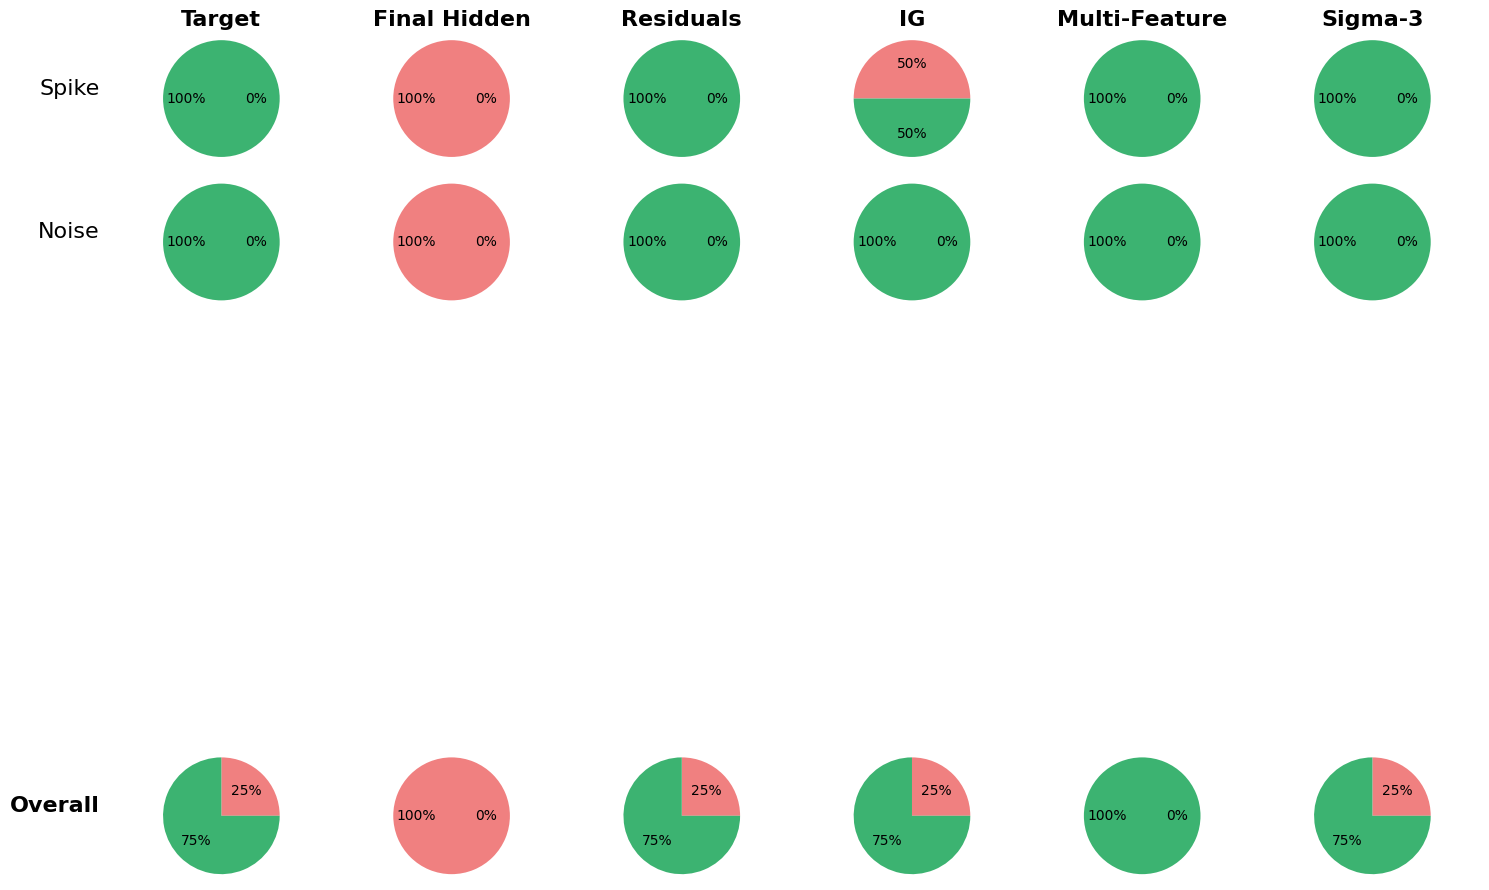

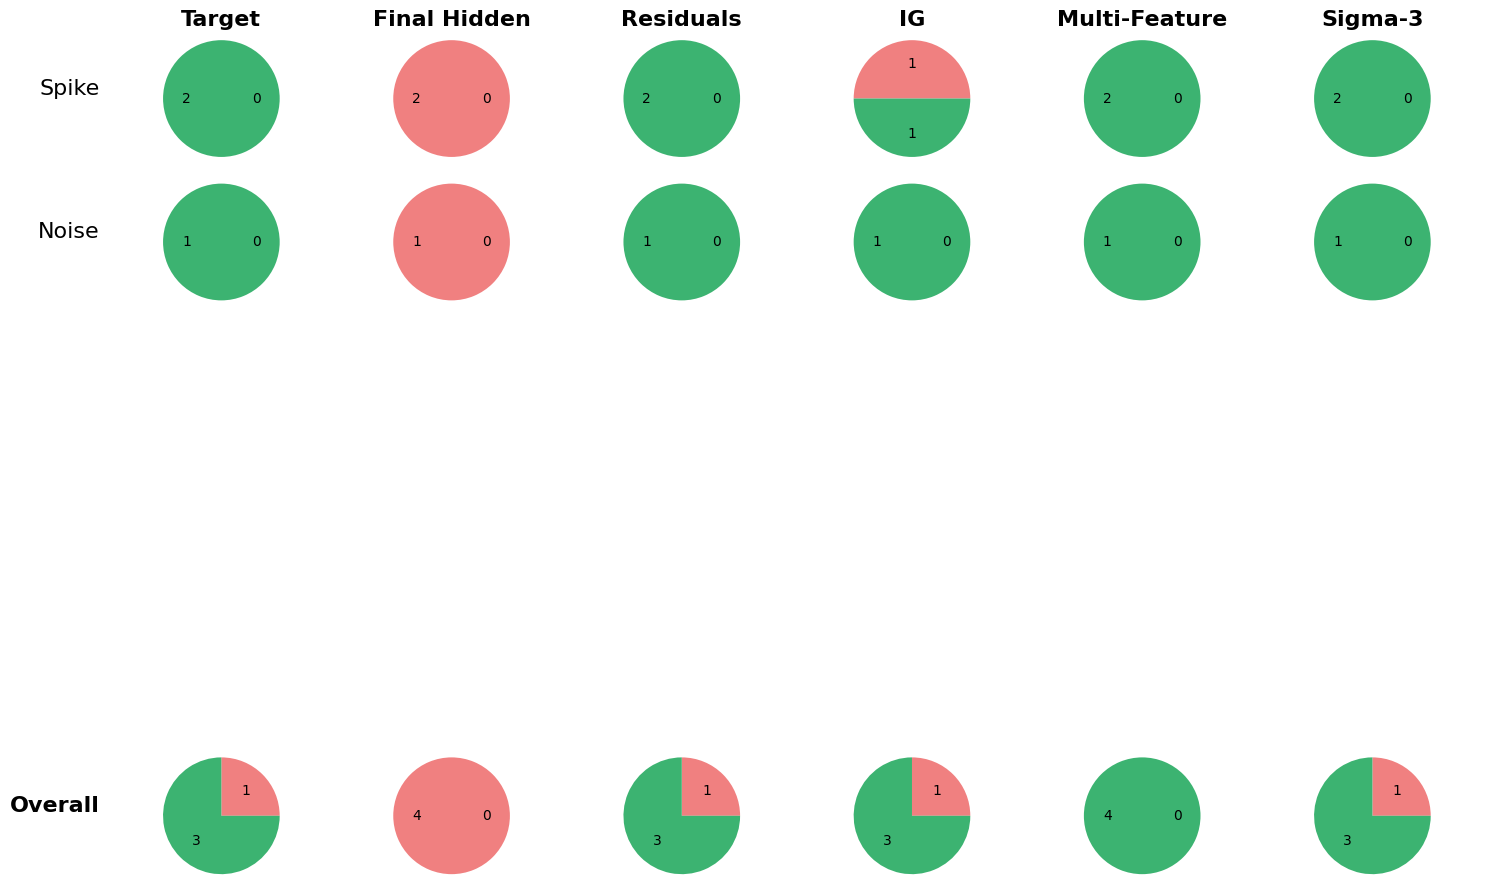

In [177]:

colors = {
    'Successful': 'mediumseagreen',
    'Unsuccessful': 'lightcoral'
}

to_show = ["percentage", "count"]
for show in to_show:
    # Create your figure
    fig, ax = plt.subplots(len(succ_unsucc), len(succ_unsucc["Overall"]["Method"]), figsize=(15, 9))

    # Iterate over the data
    iter_order = ['Spike', 'Noise', 'Frozen', 'Offset', 'Drift', 'Overall']
    for i, key in enumerate(iter_order):
        df = pd.DataFrame(succ_unsucc[key], columns=["Method", "Unsuccessful", "Successful"])
        df.set_index("Method", inplace=True)

        # ensure that the total sum is not zero
        if df.sum().sum() == 0:
            # set empty plot
            for j, method in enumerate(df.index):
                ax[i, j].axis('off')
            continue


        # Loop over each method and plot a pie chart
        for j, method in enumerate(df.index):
            # Get the data (Unsuccessful, Successful)
            data = [df.loc[method, 'Unsuccessful'], df.loc[method, 'Successful']]
            # Plot the pie chart
            ax[i, j].pie(data, 
                        #labels=['Unsuccessful', 'Successful'], 
                        # show count
                        autopct=lambda p: '{:.0f}'.format(p * sum(data) / 100) if show=="count" else '{:.0f}%'.format(p),
                        startangle=0,
                        colors=[colors['Unsuccessful'], colors['Successful']])

            ax[i, j].axis('equal')  # Equal aspect ratio ensures the pie chart is circular

            if i == 0:
                ax[i, j].set_title(method, fontsize=16, fontweight='bold')
            if j == 0:  
                fontweight = "bold" if key == "Overall" else None
                ax[i, j].set_ylabel(key, fontsize=16, rotation=0, labelpad=10, ha='right', fontweight=fontweight)
                ax[i, j].yaxis.set_major_formatter(formatter)

        #break

    # Adjust layout for clear spacing
    plt.tight_layout()
    plt.savefig(save_folder / f'successful_unsuccessful_{show}.png')
    plt.show()
    plt.close()

# Binned Anomaly Intervals

In [178]:
from scipy.interpolate import interp1d

In [179]:
def get_decision_values(results, key, start_end, n_bins=10):

    # Create a fixed number of bins
    normalized_x = np.linspace(0, 1, n_bins)

    # Iterate through each 
    decision_values = []
    for start, end in start_end:
        # extract the decision function values
        decision_segment = results[key]['Decision Function'][start:end+1]

        if len(decision_segment) == 1:
            # If there's only one value, repeat it for all bins
            normalized_decision_values = np.full(n_bins, decision_segment[0])
        else:
            # Original x-coordinates (normalized from 0 to 1)
            original_x = np.linspace(0, 1, len(decision_segment))
            
            # Interpolation function
            interp_func = interp1d(original_x, decision_segment, kind='linear', bounds_error=False, fill_value="extrapolate")
            
            # Resample to fixed 10 points
            normalized_decision_values = interp_func(normalized_x)
        
        decision_values.append(normalized_decision_values)

    return np.array(decision_values)

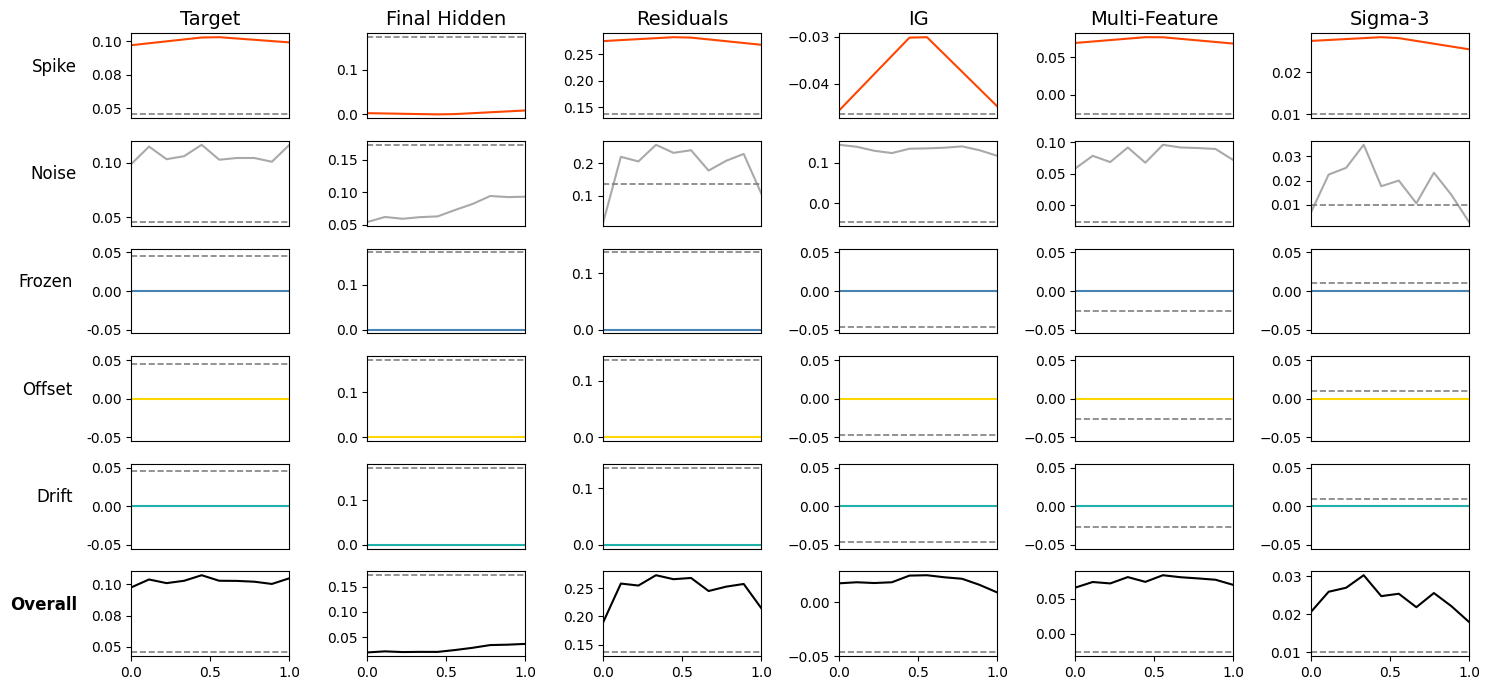

In [180]:
fig, axes = plt.subplots(len(data_label_hue_order), len(methods), figsize=(15, 7))#, sharey=True)

n_bins = 10
normalized_x = np.linspace(0, 1, n_bins)  # Create normalized positions

binned_decision_values = {}
start_times = {}
# For each method
for i, key in enumerate(methods):
    data_label = results['Data Label']
    binned_decision_values[key] = {}
    start_times[key] = {}
    # For each
    j=0
    for label in data_label_hue_order[::-1]:
        if label == 'Original':
            #continue
            # jsut use this to compute the overall
            label = "Overall"
            mask = np.array(data_label) != 'Original'
            color = 'black'
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
            color = data_label_hue_map[label]
        
        # filter for starts based on the starts in _anomaly_start_end and mask
        start_end = [_anomaly_start_end[i] for i, (start, end) in enumerate(_anomaly_start_end) if mask[start]]

        # Get the decision values
        decision_values = get_decision_values(results, key, start_end, n_bins)
        binned_decision_values[key][label] = decision_values
        # Store the start times
        start_times[key][label] = [results["Starttime"][start] for start, _ in start_end]

        # Average the decision values
        average_decision_values = np.mean(decision_values, axis=0) if len(decision_values) > 0 else np.zeros(n_bins)
        # Plot the average decision values as a line
        axes[j, i].plot(normalized_x, average_decision_values, label=label, color=color)
        threshold = results[key]["Optimal Threshold"]
        axes[j, i].axhline(threshold, color='grey', linestyle='--', label='Threshold', linewidth=1.2)
        axes[j, i].set_xlim([0, 1])
        axes[j, i].set_xticks([])
        #axes[j, i].set_yticks([])
        if j == 0:
            axes[j, i].set_title(key, fontsize=14)
        if i == 0:
            fontweight = 'bold' if label == 'Overall' else 'normal' 
            axes[j, i].set_ylabel(label, fontsize=12, rotation=0, labelpad=10, ha='right', fontweight=fontweight)
            axes[j, i].yaxis.set_major_formatter(formatter)
        j+=1
    
    axes[j-1, i].set_xticks([0, 0.5, 1])



plt.tight_layout()
plt.savefig(save_folder / 'binned_anomaly_intervals.png')
plt.show()
plt.close()


# Qualitative examples

For:
- Most accurate detection
- Least accurate detection
- Most certain non-anomaly


### Identify detections

In [192]:
# ignore sigma 3 and overall
_methods = methods[:-1]
print(_methods)
_anomalies = data_label_hue_order[1:][::-1]
print(_anomalies)

['Target', 'Final Hidden', 'Residuals', 'IG', 'Multi-Feature']
['Spike', 'Noise', 'Frozen', 'Offset', 'Drift']


In [193]:
binned_decision_values = {}
anomaly_intervals = {}
# For each method
for i, key in enumerate(_methods):
    data_label = results['Data Label']
    binned_decision_values[key] = {}
    # For each
    for label in _anomalies:
        if label == 'Original':
            continue
        else:
            # Anomaly filter
            mask = (np.array(data_label) == label)
        
        # filter for starts based on the starts in _anomaly_start_end and mask
        start_end = [anomaly_start_end[i] for i, (start, end) in enumerate(anomaly_start_end) if mask[start]]
        # If empty then continue
        if len(start_end) == 0:
            continue

        # Get the decision values
        decision_values = get_decision_values(results, key, start_end, n_bins)
        binned_decision_values[key][label] = decision_values
        # Store the start times
        if i == 0:
            anomaly_intervals[label] = {
                "Starts": [results["Starttime"][start] for start, _ in start_end],
                "Ends": [results["Starttime"][end] for _, end in start_end]
            }
            #[results["Starttime"][start] for start, _ in start_end]

In [194]:
# get filter anomalies in case of empty
_anomalies = [label for label in _anomalies if label in binned_decision_values[key]]
print(_anomalies)

['Spike', 'Noise', 'Frozen']


In [198]:
detections = {
    'Most Accurate': {},
    'Least Accurate': {},
    'Most Certain Non-Anomaly': {},
}

# Ensure equal count per anomaly
for anomaly in _anomalies:
    counts = np.unique([len(binned_decision_values[method][anomaly]) for method in _methods])
    assert len(counts) == 1, f"Counts are not equal for {anomaly}: {counts}"


# Get the most accurate detection and the least accurate detection
for anomaly in _anomalies:
    n_anomalies = len(binned_decision_values[_methods[0]][anomaly])
    # For each instance of the anomaly type, extend the decision values
    decision_values = []
    for i in range(n_anomalies):
        decision_values.append(
            np.mean([binned_decision_values[method][anomaly][i] for method in _methods])
        )
    # Find the most accurate detection
    most_accurate = np.argmax(decision_values)
    # Find the least accurate detection
    least_accurate = np.argmin(decision_values)
    detections['Most Accurate'][anomaly] = {
            'Avg. Decision Values': decision_values[most_accurate],
            'Start Time': anomaly_intervals[anomaly]["Starts"][most_accurate],
            'End Time': anomaly_intervals[anomaly]["Ends"][most_accurate]
    }
    detections['Least Accurate'][anomaly] = {
            'Avg. Decision Values': decision_values[least_accurate],
            'Start Time': anomaly_intervals[anomaly]["Starts"][least_accurate],
            'End Time': anomaly_intervals[anomaly]["Ends"][least_accurate]
    }

# Get the most certain non-anomaly
method = "Multi-Feature" # using only this method
n_top = 2

# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results['Actual']) if value == 1]
_, anomaly_start_end = find_unterrupted_sequences(indices_of_ones, 0)

# Get the start and end of each anomaly
indices_of_ones = [index for index, value in enumerate(results["Multi-Feature"]["Predicted"].astype(int)) if value == 1]
_, predicted_start_end = find_unterrupted_sequences(indices_of_ones, 0)

decision_values = []
for start, end in predicted_start_end:
    # Ensure not part of an anomaly
    if np.any([start <= anomaly[0] <= end for anomaly in anomaly_start_end]):
        continue
    # Get the decision values
    decision_values.append(results[method]['Decision Function'][start:end+1].mean())

for top in range(n_top):
    most_certain_non_anomaly = np.argsort(decision_values)[-(top+1)]
    detections['Most Certain Non-Anomaly'][f'Top {top+1}'] = {
        'Avg. Decision Values': decision_values[most_certain_non_anomaly],
        'Start Time': results['Starttime'][predicted_start_end[most_certain_non_anomaly][0]],
        'End Time': results['Starttime'][predicted_start_end[most_certain_non_anomaly][1]]
    }





### Difference vs. decision function plot

In [270]:
from fault_management_uds.evaluate_detection import load_model_outputs
from fault_management_uds.data.dataset import load_data, load_dataframe_from_HDF5
from fault_management_uds.plots import visualize_error_span, set_meaningful_xticks

from fault_management_uds.data.load import import_metadata

metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')

In [233]:
# Load the model outputs
outputs, column_2_idx = load_model_outputs(anomalous_path / data_type)

Outputs: (9213, 90)
Column 2 idx: ['Starttime', 'Valid index', 'Data label', 'Target', 'Residual', 'Prediction', 'Final hidden', 'IG', 'Residuals']
Outputs after features: (9212, 90)


In [199]:
detections['Most Accurate'].keys()

dict_keys(['Spike', 'Noise', 'Frozen'])

In [276]:
# Select what to plot: ['Most Accurate', 'Least Accurate', 'Most Certain Non-Anomaly']
detection_theme = "Most Accurate"
# Select the detection
# Either: 'Spike', 'Noise', 'Frozen', 'Offset', 'Drift'
# Or: 'Top 1', 'Top 2'...
detection_type = "Noise"
# create a save folder
_save_folder = save_folder / detection_theme / detection_type
os.makedirs(_save_folder, exist_ok=True)

# Extract
detection = detections[detection_theme][detection_type]
_starttime = detection['Start Time']
starttime = pd.to_datetime(_starttime)
_endtime = detection['End Time']
endtime = pd.to_datetime(_endtime)
timestamps = pd.date_range(starttime, endtime, freq='1min')
detection

{'Avg. Decision Values': 0.11665705606403928,
 'Start Time': 1525182060000000000,
 'End Time': 1525184640000000000}

In [266]:
# Get the data to visualize anomaly
go_back_forth = 20 # minutes
show_start = starttime - pd.Timedelta(minutes=go_back_forth)
show_end = endtime + pd.Timedelta(minutes=go_back_forth)
show_timestamps = pd.date_range(start=show_start, end=show_end, freq='1min')
# create the indicator
indicator = np.zeros(len(show_timestamps))
mask = (show_timestamps >= starttime) & (show_timestamps <= endtime)
indicator[mask] = 1

In [264]:
# Extract from the model outputs
starttimes = pd.to_datetime(outputs[:, column_2_idx['Starttime']].flatten())
# Identify start and end indices
start_idx = np.where(starttimes == show_start)[0][0]
end_idx = np.where(starttimes == show_end)[0][0]
# Extract the data
data = outputs[start_idx:end_idx+1, :]
polluted_data = pd.DataFrame(data[:, column_2_idx['Target']], index=show_timestamps, columns=['value'])

In [271]:

# Get the data
sensor_name = config['dataset_args']['endogenous_vars'][0]
true_data, _, _, _ = load_dataframe_from_HDF5(
    config['dataset_args']['data_file_path'], 
    #f"combined_data/{config['dataset_args']['data_group']}", 
    f"combined_data/clean", 
    #columns=config['dataset_args']['endogenous_vars'],
    columns=['5425', sensor_name],
    starttime=show_start, 
    endtime=show_end, 
    complete_range=True
)
true_data.rename(columns={config['dataset_args']['endogenous_vars'][0]: 'value'}, inplace=True)


unit = metadata[metadata['IdMeasurement'] == sensor_name]['UnitAlias'].values[0]


#### Visualize the actual time line

In [274]:
data_dict = {
    'original': true_data,
    '5425': true_data,
    'polluted': polluted_data,
    'start': show_start,
    'end': show_end,
    'indicator_dict': {
        'indicator': indicator,
        'colormap': {
            0: 'none',
            1: 'firebrick',
        }
    }
}

In [283]:
def visualize_rain(ax, title, data_dict, marker='o', linewidth=1):
    ax.set_title(title, fontsize=20)
    ### Visualize rain data
    rain_gauge = '5425'
    ax.plot(data_dict["original"][rain_gauge].index, data_dict["original"][rain_gauge],
        label=f'Rain gauge {rain_gauge}', color='darkblue',
        linewidth=linewidth, linestyle='-', 
        marker=marker, markersize=1, alpha=1)
    ax.set_ylabel('Rain (mm)')
    ax.legend(loc='upper right')
    ax.set_xticks([])
    # set y limits based on 0 and max wrt both
    ax.set_ylim(-1, data_dict["original"]['5425'].max()+1)
    ax.set_xlim(data_dict['start'], data_dict['end'])
    return ax

def visualize_injected_synthetics(ax, title, data_dict, unit, marker='o'):

    # visualize the sensor data; severities
    ax.set_title(title, fontsize=20)
    ax.plot(data_dict['original'].index, data_dict['original'].value, 
        label='Original data', color='grey', 
        linewidth=1, linestyle='-', 
        marker='', markersize=1, alpha=1)

    ax.plot(data_dict['polluted'].index, data_dict['polluted'].value, 
        label='Erroneous data', color='grey', 
        linewidth=2, linestyle='-', 
        marker=marker, markersize=2, alpha=1)
    # visualzie error span
    ax = visualize_error_span(ax, data_dict['indicator_dict'], data_dict['start'], data_dict['end'], adjust='full-point')
    ax.set_xlim(data_dict['start'], data_dict['end'])
    ax.set_ylabel(unit)
    ax.legend()
    ax.set_xticks([])
    return ax

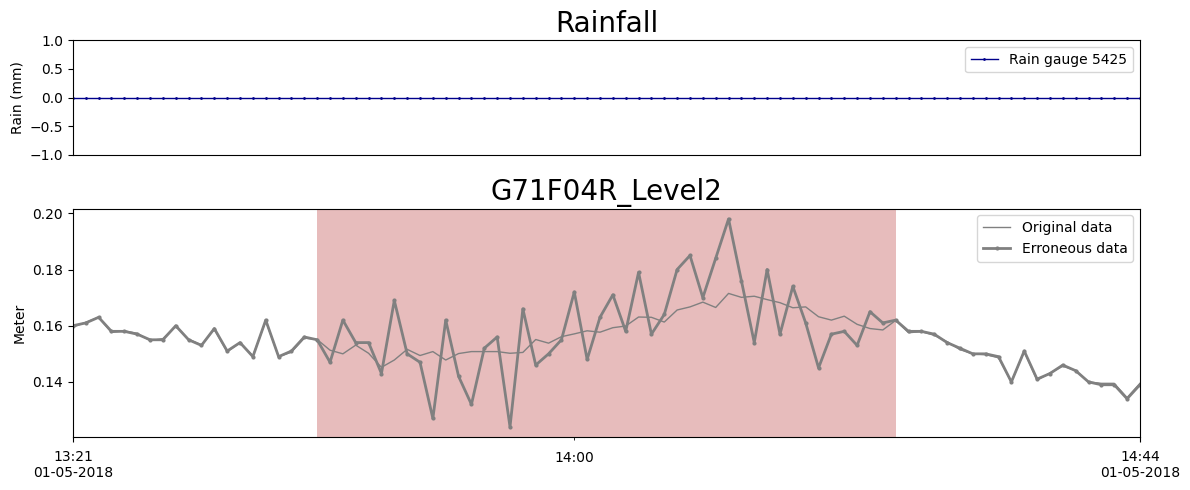

In [286]:
# Plot the time series
fig, axs = plt.subplots(2, 1, figsize=(12, 5), height_ratios=[1, 2])
axs[0] = visualize_rain(axs[0], 'Rainfall', data_dict)
axs[1] = visualize_injected_synthetics(axs[1], sensor_name, data_dict, unit)
axs[-1] = set_meaningful_xticks(axs[-1], data_dict['start'], data_dict['end'])
plt.tight_layout()
plt.savefig(_save_folder / 'anomaly_visualization.png', dpi=150)
plt.show()
plt.close()


### Feature plot